In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

2022-09-14 19:57:29.320026: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-09-14 19:57:29.320045: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.models.UTS_models import EntropySensor
from src.visualization import plot_result

In [4]:
model_store_path = './saved_models/'

In [5]:
pd.set_option('display.max_rows', 200)

# Загрузка данных

### Загрузка из подготовленных CSV

In [6]:
path = './data/Dec2019.csv'
df = pd.read_csv(path, parse_dates=True, index_col=[0])
df.replace({'Active': 1, 'Inactive': 0}, inplace=True)

In [7]:
df_train = df.loc[:'2019-12-06 12:30:00'].copy()
df_train.head(3)

,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,AIT202.Pv,...,FIT601.Pv,P601.Status,P602.Status,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm
t_stamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 10:05:00,3.0,658.661255,0.0,1.0,2.0,1.0,2.0,2.313523,35.21533,8.205781,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1
2019-12-06 10:05:01,3.0,659.171600,0.0,1.0,2.0,1.0,2.0,2.311857,35.21533,8.205781,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1
2019-12-06 10:05:02,3.0,659.681800,0.0,1.0,2.0,1.0,2.0,2.311601,35.21533,8.208344,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1


In [8]:
df_test = df.loc['2019-12-06 12:30:00':]

In [9]:
df_test = df.loc['2019-12-06 12:30:00':]

anomaly_idxs = [['2019-12-06 12:30:55', '2019-12-06 12:33:55'],
                ['2019-12-06 12:43:55', '2019-12-06 12:46:55'],
                ['2019-12-06 12:56:55', '2019-12-06 12:59:55'], 
                ['2019-12-06 13:09:55', '2019-12-06 13:12:55'], 
                ['2019-12-06 13:22:55', '2019-12-06 13:25:55']]

df_test['anomaly'] = 0

for idx in anomaly_idxs:
    df_test['anomaly'].loc[idx[0]:idx[1]] = 1

df_test.head(3)

,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,AIT202.Pv,...,P601.Status,P602.Status,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm,anomaly
t_stamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 12:30:00,2.0,781.836400,0.0,1.0,2.0,1.0,2.0,2.334924,37.330174,8.006153,...,1.0,1.0,1.0,0,0,1,0,0,1,0
2019-12-06 12:30:01,2.0,781.404663,0.0,1.0,2.0,1.0,2.0,2.333259,37.330174,8.006153,...,1.0,1.0,1.0,0,0,1,0,0,1,0
2019-12-06 12:30:02,2.0,781.090637,0.0,1.0,2.0,1.0,2.0,2.331593,37.330174,8.006153,...,1.0,1.0,1.0,0,0,1,0,0,1,0


In [10]:
summary = {}

## Подготовка train/test

In [11]:
window_size = 20

x_train, x_test, y_test = get_traintest(df_train[['FIT101.Pv']].copy(), 
                                        df_test[['FIT101.Pv','anomaly']].copy(), 
                                        window_size=window_size)

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 3596, 1: 905})
Create sequences with window size 20...
Размеры выборок:
            x_train: (8682, 20, 1)
            x_test: (4482, 20, 1)
            y_test: (4482, 20)


## Анализ энтропии

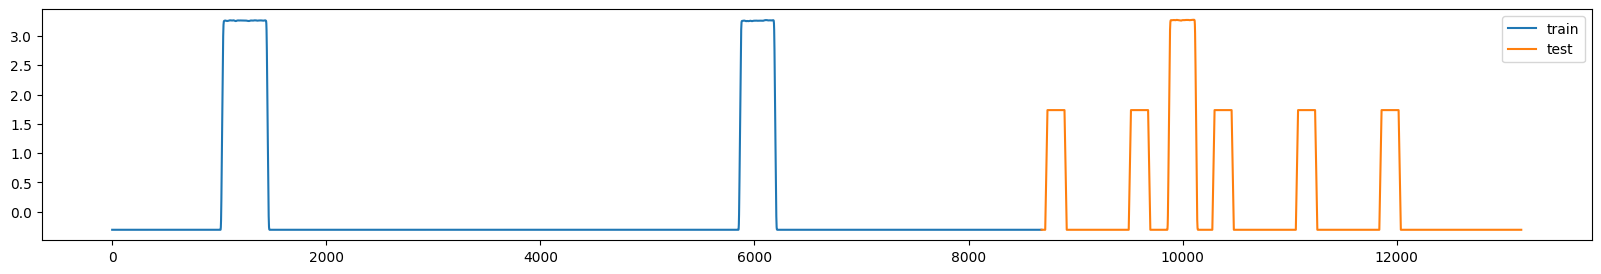

In [12]:
test_len, train_len = len(x_test), len(x_train)

plt.figure(figsize=(20,3))
plt.plot(range(train_len), np.mean(x_train, axis=1), label='train')
plt.plot(range(train_len, train_len+test_len), np.mean(x_test, axis=1), label='test')
plt.legend()
plt.show()

2022-09-14 19:57:30.694166: can't find saved model, fit model...


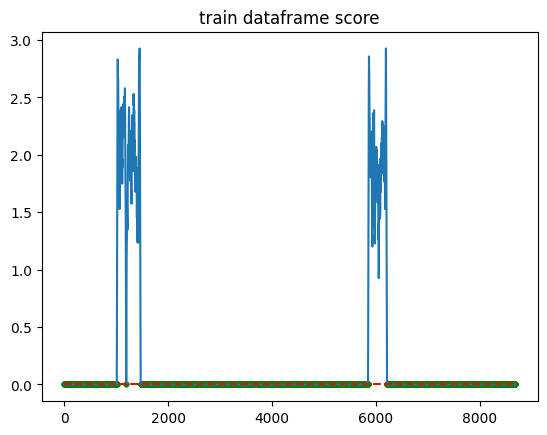

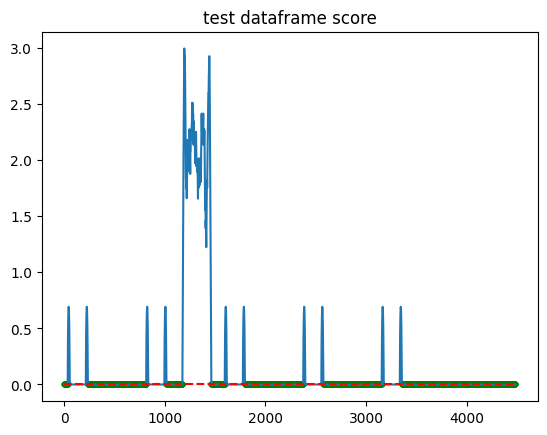

SWAT_Dec19_UTS_entropy
f1_score: 0.94
accuracy_score: 0.98
precision_score: 1.00
recall_score: 0.89


In [13]:
description='SWAT_Dec19_UTS_entropy'

model = EntropySensor()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description, window_size=window_size)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()

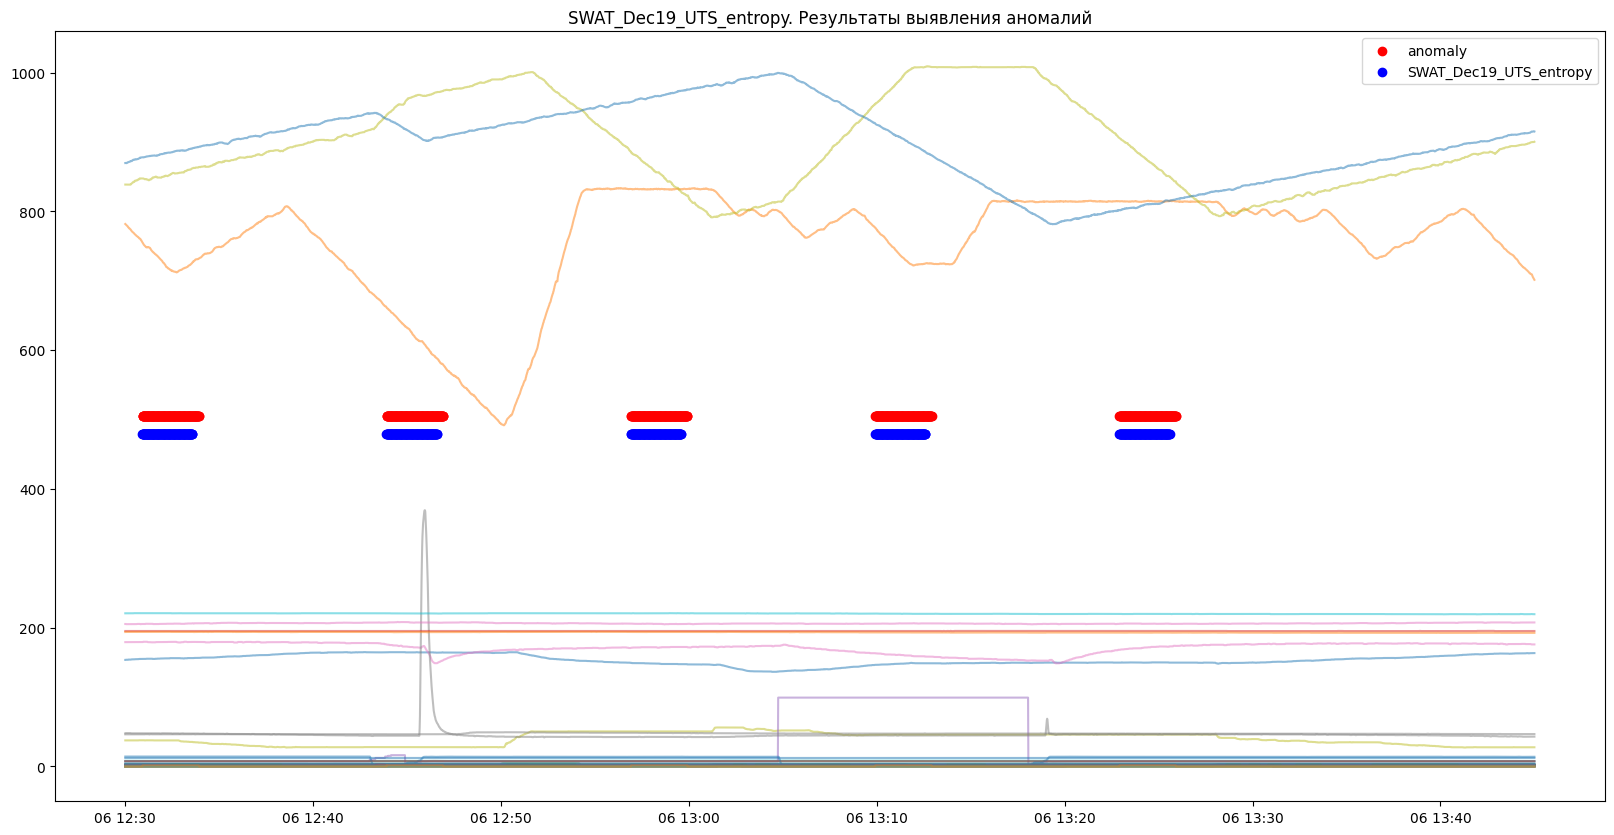

In [14]:
plot_result(df_test, y_test[:,0], y_pred, descr=description)

## Вывод
Расчет энтропии позволяет с высокой точностью определить факт подмены одной непрерывной величины на статичное значение